In [1]:
import os
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#open debate summary
def open_debate_summary(debate_id):
    #list all files in data/debates/debate_id/summaries
    files = os.listdir(f"data/debates/{debate_id}/summaries")
    #open each file and read the json
    data = []
    for file in files:
        with open(f"data/debates/{debate_id}/summaries/{file}", "r") as f:
            data.append(json.load(f))
    
    return data

def open_reconstructed_summaries(debate_id):
    #list all files in data/debates/debate_id/reconstructed_summaries
    files = os.listdir(f"data/debates/{debate_id}/reconstructed_summaries/qwen3:30b-a3b")
    collected_data = []
    #open each file and read the json
    data_original, data_english = [], []
    for file in files:
        if file not in collected_data:
            if "_org_" in file:
                with open(f"data/debates/{debate_id}/reconstructed_summaries/qwen3:30b-a3b/{file}", "r") as f:
                    j = json.load(f)
                    for o in j:
                        o['zero_shot'] = 'zero_shot' in file
                    data_original.extend(j)
                collected_data.append(file)
                file = file.replace("_org_", "_en_")
                with open(f"data/debates/{debate_id}/reconstructed_summaries/qwen3:30b-a3b/{file}", "r") as f:
                    j = json.load(f)
                    for o in j:
                        o['zero_shot'] = 'zero_shot' in file
                    data_english.extend(j)
                collected_data.append(file)
            if "_org." in file:
                with open(f"data/debates/{debate_id}/reconstructed_summaries/qwen3:30b-a3b/{file}", "r") as f:
                    j = json.load(f)
                    for o in j:
                        o['zero_shot'] = 'zero_shot' in file
                    data_original.extend(j)
                collected_data.append(file)
                file = file.replace("_org.", "_en.")
                with open(f"data/debates/{debate_id}/reconstructed_summaries/qwen3:30b-a3b/{file}", "r") as f:
                    j = json.load(f)
                    for o in j:
                        o['zero_shot'] = 'zero_shot' in file
                    data_english.extend(j)
                collected_data.append(file)
    
    return data_original, data_english

In [3]:
files = os.listdir(f"data/debates/CRE-20060118-ITEM-008/reconstructed_summaries/qwen3:30b-a3b")
files 

['CRE-20060118-ITEM-008_claude_org_zero_shot.json',
 'CRE-20060118-ITEM-008_gpt_structured_en.json',
 'CRE-20060118-ITEM-008_phi4:14b_en_zero_shot.json',
 'CRE-20060118-ITEM-008_claude_structured_org.json',
 'CRE-20060118-ITEM-008_phi4:14b_structured_en.json',
 'CRE-20060118-ITEM-008_claude_structured_hierarchical_org.json',
 'CRE-20060118-ITEM-008_phi4:14b_structured_hierarchical_org.json',
 'CRE-20060118-ITEM-008_claude_en_zero_shot.json',
 'CRE-20060118-ITEM-008_phi4:14b_structured_org.json',
 'CRE-20060118-ITEM-008_claude_structured_hierarchical_en.json',
 'CRE-20060118-ITEM-008_claude_structured_en.json',
 'CRE-20060118-ITEM-008_gpt_structured_org.json',
 'CRE-20060118-ITEM-008_phi4:14b_structured_hierarchical_en.json',
 'CRE-20060118-ITEM-008_phi4:14b_org_zero_shot.json']

In [4]:
data = []
for debate in os.listdir('data/debates'):
    data.extend(open_debate_summary(debate))

In [5]:
data_original, data_english = [], []
for debate_id in os.listdir("data/debates"):
    d_o, d_e = open_reconstructed_summaries(debate_id)
    data_original.extend(d_o)
    data_english.extend(d_e)

In [6]:
from experiments.utils.bertscore import compute_bertscore_advanced
from tqdm import tqdm

def cross_lingual_eval(data):
    """
    compare multilingual BERTScore between the original text and (i) summary_english (ii) summary_original
    """

    original_text = []
    summary_english = []
    summary_original = []
    meta = []

    for d in tqdm(data):
        summ_eng = json.dumps(d['summary_english'])
        summ_orig = json.dumps(d['summary_original'])
        if len(summ_eng) > 100 and len(summ_orig) > 100:
            original_text.append(d['original'])
            summary_english.append(summ_eng)
            summary_original.append(summ_orig)
            meta.append(d)

    #calculate BERTScore for original text and summary_english
    bertscore_original_english = compute_bertscore_advanced(references=original_text, candidates=summary_english)
    bertscore_original_original = compute_bertscore_advanced(references=original_text, candidates=summary_original)

    for i in range(len(meta)):
        meta[i]['bertscore_original_english'] = bertscore_original_english['f1'][i]
        meta[i]['bertscore_original_original'] = bertscore_original_original['f1'][i]

    return meta


In [7]:
import re

def cleanup_string(s):
    """
    remove text between think tags
    """
    if s:
        parts = s.split("</think>")
    else:
        parts = []
        
    if len(parts) > 1:
        return parts[-1]
    else:
        return s

def cross_lingual_attention(data_original, data_english):

    """
    compare multilingual BERTScore between the original text and (i) reconstructed_position in english and (ii) reconstructed_position in the original language
    """
    original_text = []  
    reconstructed_position_english = []
    reconstructed_position_original = []
    meta = []

    for d_o, d_e in zip(data_original, data_english):
        original_text.append(d_o['original'])
        reconstructed_position_english.append(cleanup_string(d_e['reconstructed_position']))
        reconstructed_position_original.append(cleanup_string(d_o['reconstructed_position']))
        d_o['reconstructed_position_original'] = cleanup_string(d_o['reconstructed_position'])
        d_o['reconstructed_position_english'] = cleanup_string(d_e['reconstructed_position'])
        meta.append(d_o)

    bertscore_original_english = compute_bertscore_advanced(references=original_text, candidates=reconstructed_position_english)
    bertscore_original_original = compute_bertscore_advanced(references=original_text, candidates=reconstructed_position_original)

    for i in range(len(meta)):
        meta[i]['bertscore_original_english'] = bertscore_original_english['f1'][i]
        meta[i]['bertscore_original_original'] = bertscore_original_original['f1'][i]

    return meta

In [8]:
import pandas as pd

In [9]:
def check_empty(summary_s):
    """
    check if the summary is empty
    """
    if isinstance(summary_s, dict):
        summary_d = summary_s
    else:
        if '```json' in summary_s:
            summary_s = summary_s[8:-3]
        try:
            summary_d = json.loads(summary_s)
        except:
            return True

    if len(summary_d['headline']) < 10:
        return True
    else:
        return False

In [10]:
meta_2 = cross_lingual_attention(data_original, data_english)

Token indices sequence length is longer than the specified maximum sequence length for this model (1007 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1007 > 512). Running this sequence through the model will result in indexing errors


In [11]:
res_2 = pd.DataFrame(meta_2)

In [12]:
res_2['empty_english'] = res_2['summary_english'].map(check_empty)
res_2['empty_original'] = res_2['summary_original'].map(check_empty)

res_2['empty_english'].value_counts()
res_2['empty_original'].value_counts()

empty_original
False    6347
True     1146
Name: count, dtype: int64

In [13]:
claude = res_2[(res_2['generator_src_model']=='claude')]

In [14]:
lang_counts = claude[~claude['zero_shot']]['lang'].value_counts()
language_support_order = list(lang_counts[lang_counts>=10].index)

In [15]:
import numpy as np 
ids = res_2[['debate_id','intervention_id']].drop_duplicates()
mapping = ids.groupby('debate_id')['intervention_id'].agg(lambda x: np.array(sorted(x)))
def get_speaker_order(debate_id, intervention_id):
    return np.where(mapping[debate_id] == intervention_id)[0][0]/len(mapping[debate_id])
claude['relative_speaker_position'] = claude.apply(lambda x: get_speaker_order(x['debate_id'], x['intervention_id']), axis=1)

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_51031/1647237089.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude['relative_speaker_position'] = claude.apply(lambda x: get_speaker_order(x['debate_id'], x['intervention_id']), axis=1)


In [16]:
claude['speaker_bin'] = claude['relative_speaker_position'].apply(lambda x: int(x*20))

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_51031/626589489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude['speaker_bin'] = claude['relative_speaker_position'].apply(lambda x: int(x*20))


In [17]:
lang_counts =claude[claude['zero_shot']]['lang'].value_counts()
lang_rank = lang_counts.rank(ascending=False)
claude['lang_rank'] = claude['lang'].map(lang_rank)/len(lang_rank)

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_51031/2514256082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude['lang_rank'] = claude['lang'].map(lang_rank)/len(lang_rank)


In [18]:
import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel

In [19]:
claude_zero_shot = claude[claude['zero_shot']]
claude_hierarchical = claude[~claude['zero_shot']]

In [20]:
with open('data/language_counts.json', 'r') as f:
    counts = json.load(f)


def lang_rank(lang):

    if counts[lang] > 5000000:
        return 'high'
    elif counts[lang] > 1000000:
        return 'medium'
    else:
        return 'low'

claude['lang_rank'] = claude['lang'].apply(lambda x: lang_rank(x))

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_51031/1632536727.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude['lang_rank'] = claude['lang'].apply(lambda x: lang_rank(x))


In [21]:
claude['lang_count'] = claude['lang'].map(counts)

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_51031/3712928980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude['lang_count'] = claude['lang'].map(counts)


In [22]:
claude['speech_id'] = claude['debate_id'].astype(str) + '_' + claude['intervention_id'].astype(str)

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_51031/2440442958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude['speech_id'] = claude['debate_id'].astype(str) + '_' + claude['intervention_id'].astype(str)


In [23]:
claude.columns

Index(['speaker', 'english', 'lang', 'original', 'agenda_item', 'debate_id',
       'intervention_id', 'summary_english', 'summary_original', 'model',
       'method', 'formatted_summary', 'reconstructed_position',
       'generator_model_name', 'generator_model_type', 'generator_grouped',
       'generator_shuffle', 'generator_prompt', 'generator_incremental',
       'generator_hierarchical', 'generator_src_model', 'zero_shot',
       'reconstructed_position_original', 'reconstructed_position_english',
       'bertscore_original_english', 'bertscore_original_original',
       'empty_english', 'empty_original', 'relative_speaker_position',
       'speaker_bin', 'lang_rank', 'lang_count', 'speech_id'],
      dtype='object')

In [24]:
data = claude[~claude['speaker'].str.contains('President.')].melt(id_vars = ['speech_id', 'lang_rank', 'zero_shot', 'generator_hierarchical', 'relative_speaker_position'], value_vars = ['bertscore_original_original', 'bertscore_original_english'], var_name = 'score_type', value_name = 'bertscore')

In [25]:
data['translated'] =data['score_type'] != 'bertscore_original_original'

In [26]:
data.drop('score_type', axis = 1).to_csv('data/claude_data.csv', index = False)

In [27]:
claude['speech_id'] = claude['debate_id'].astype(str) + '_' + claude['intervention_id'].astype(str)

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_51031/2440442958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude['speech_id'] = claude['debate_id'].astype(str) + '_' + claude['intervention_id'].astype(str)


In [28]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
from statsmodels.othermod.betareg import BetaModel
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

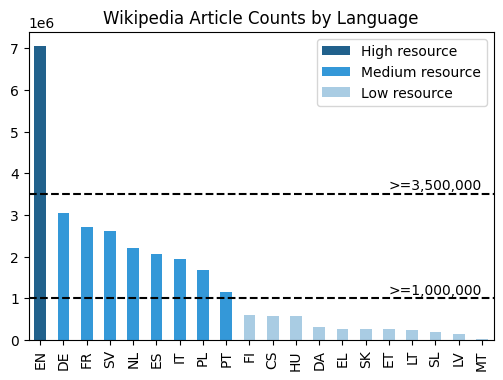

In [29]:
# Define resource level thresholds
high_threshold = 3500000
med_threshold = 1000000

cmap = {
    'high': '#21618c',
    'medium': '#3498d8',
    'low': '#a9cce3'
}

# Get language counts and sort
lang_counts = claude.groupby('lang')['lang_count'].mean().sort_values(ascending=False)

# Create color map based on resource level
colors = [cmap['high'] if x >= high_threshold else  
          cmap['medium'] if x >= med_threshold else 
          cmap['low']                               
          for x in lang_counts]

# Plot with colors
ax = lang_counts.plot(kind='bar', figsize=(6,4), color=colors)

# Add threshold lines and legend
ax.axhline(y=high_threshold, color='black', linestyle='--', 
           label=f'High resource threshold ({high_threshold:,})')
ax.text(len(lang_counts)-1, high_threshold+100000, f'>={high_threshold:,}', 
        horizontalalignment='right')

ax.axhline(y=med_threshold, color='black', linestyle='--',
           label=f'Medium resource threshold ({med_threshold:,})')
ax.text(len(lang_counts)-1, med_threshold+100000, f'>={med_threshold:,}',
        horizontalalignment='right')

# Add legend entries for resource level colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=cmap['high'], label='High resource'),
    Patch(facecolor=cmap['medium'], label='Medium resource'), 
    Patch(facecolor=cmap['low'], label='Low resource')
]
ax.legend(handles=legend_elements)

#change x label:
ax.set_xlabel('')
plt.title('Wikipedia Article Counts by Language')
plt.savefig('figures/language_counts.png')

In [30]:
df = pd.read_csv('data/claude_data.csv')

In [31]:
df['hierarchical_1'] = ~df['zero_shot'] & ~df['generator_hierarchical']
df['hierarchical_2'] = ~df['zero_shot'] & df['generator_hierarchical']

In [32]:
df[df['hierarchical_1']]

,speech_id,lang_rank,zero_shot,generator_hierarchical,relative_speaker_position,bertscore,translated,hierarchical_1,hierarchical_2
76,CRE-20060404-ITEM-006_2-020,high,False,False,0.025000,0.664403,False,True,False
77,CRE-20060404-ITEM-006_2-021,high,False,False,0.050000,0.224527,False,True,False
78,CRE-20060404-ITEM-006_2-022,high,False,False,0.075000,0.394779,False,True,False
79,CRE-20060404-ITEM-006_2-023,high,False,False,0.100000,0.284993,False,True,False
80,CRE-20060404-ITEM-006_2-024,low,False,False,0.125000,0.303623,False,True,False
...,...,...,...,...,...,...,...,...,...
6401,CRE-20060404-ITEM-017_2-380,medium,False,False,0.666667,0.607949,True,True,False
6402,CRE-20060404-ITEM-017_2-381,high,False,False,0.714286,0.444417,True,True,False
6403,CRE-20060404-ITEM-017_2-383,high,False,False,0.809524,0.507084,True,True,False
6404,CRE-20060404-ITEM-017_2-384,high,False,False,0.857143,0.475331,True,True,False


In [ ]:
y_var = 'bertscore'
sub_df = df[~df['hierarchical_2']]

sub_df['speaker_pos_squared'] = sub_df['relative_speaker_position']**2

sub_df['hierarchical_x_relative_speaker_position'] = sub_df['hierarchical_1'] * sub_df['relative_speaker_position']
sub_df['hierarchical_x_speaker_pos_squared'] = sub_df['hierarchical_1'] * sub_df['speaker_pos_squared']
sub_df['hierarchical_x_relative_speaker_position'] = sub_df['hierarchical_2'] * sub_df['relative_speaker_position']
sub_df['hierarchical_x_speaker_pos_squared'] = sub_df['hierarchical_2'] * sub_df['speaker_pos_squared']
feature_cols = ['relative_speaker_position', 'speaker_pos_squared', 'translated', 'hierarchical_1', 'hierarchical_2'] 

reference_lang = 'language_support_high'

lang_dummies = pd.get_dummies(sub_df['lang_rank'], prefix='language_support')
sub_df = pd.concat([sub_df, lang_dummies], axis=1)

for col in feature_cols:
    for lang in lang_dummies.columns.drop(reference_lang):
        print(f'{col}_x_{lang}')
        sub_df[f'{col}_x_{lang}'] = sub_df[col] * sub_df[lang]

feature_cols += [f'{col}_x_{lang}' for col in feature_cols for lang in lang_dummies.columns.drop(reference_lang)]
feature_cols += ['hierarchical_x_relative_speaker_position', 'hierarchical_x_speaker_pos_squared']
feature_cols.extend(lang_dummies.columns.drop(reference_lang))
print(feature_cols)
X = sub_df[feature_cols].astype(float)
X = sm.add_constant(X)
y = sub_df[y_var]

# Ensure y is in (0, 1)
epsilon = 1e-5
y = sub_df[y_var].clip(lower=epsilon, upper=1 - epsilon)

model = BetaModel(y, X, link=sm.families.links.logit())
result = model.fit()  
print(result.summary())


relative_speaker_position_x_language_support_low
relative_speaker_position_x_language_support_medium
speaker_pos_squared_x_language_support_low
speaker_pos_squared_x_language_support_medium
translated_x_language_support_low
translated_x_language_support_medium
hierarchical_1_x_language_support_low
hierarchical_1_x_language_support_medium
['relative_speaker_position', 'speaker_pos_squared', 'translated', 'hierarchical_1', 'relative_speaker_position_x_language_support_low', 'relative_speaker_position_x_language_support_medium', 'speaker_pos_squared_x_language_support_low', 'speaker_pos_squared_x_language_support_medium', 'translated_x_language_support_low', 'translated_x_language_support_medium', 'hierarchical_1_x_language_support_low', 'hierarchical_1_x_language_support_medium', 'hierarchical_x_relative_speaker_position', 'hierarchical_x_speaker_pos_squared', 'language_support_low', 'language_support_medium']
                              BetaModel Results                               

In [34]:
def extract_and_plot_coefficients(result, exclude_vars=None, title="Regression Coefficients"):
    """
    Extract coefficients and confidence intervals from statsmodels result object
    and create a coefficient plot with readable variable names
    
    Parameters:
    result: statsmodels regression result object
    exclude_vars: list of variable names to exclude (e.g., ['const', 'precision'])
    title: plot title
    """
    
    if exclude_vars is None:
        exclude_vars = ['const', 'precision']  # Common exclusions for beta regression
    
    # Extract key information from result object
    coefficients = result.params
    conf_int = result.conf_int()
    pvalues = result.pvalues
    std_errors = result.bse
    
    # Create DataFrame
    coef_df = pd.DataFrame({
        'Variable': coefficients.index,
        'Coefficient': coefficients.values,
        'Std_Error': std_errors.values,
        'P_Value': pvalues.values,
        'CI_Lower': conf_int.iloc[:, 0].values,
        'CI_Upper': conf_int.iloc[:, 1].values
    })
    
    # Filter out excluded variables
    coef_df = coef_df[~coef_df['Variable'].isin(exclude_vars)]
    
    # Create readable variable names
    def clean_variable_names(var):
        """Convert technical variable names to readable labels"""
        name_mapping = {
            'const': 'Intercept',
            'relative_speaker_position': 'Speaker Position',
            'speaker_pos_squared': 'Speaker Position²',
            'translated': 'Translated Data',
            'hierarchical': 'Hierarchical Method',
            'relative_speaker_position_x_language_support_low': 'Position × Low Resource',
            'relative_speaker_position_x_language_support_medium': 'Position × Medium Resource',
            'speaker_pos_squared_x_language_support_low': 'Position² × Low Resource',
            'speaker_pos_squared_x_language_support_medium': 'Position² × Medium Resource',
            'translated_x_language_support_low': 'Translated × Low Resource',
            'translated_x_language_support_medium': 'Translated × Medium Resource',
            'hierarchical_x_language_support_low': 'Hierarchical × Low Resource',
            'hierarchical_x_language_support_medium': 'Hierarchical × Medium Resource',
            'language_support_low': 'Low Resource Language',
            'language_support_medium': 'Medium Resource Language',
            'hierarchical_x_speaker_pos_squared': 'Hierarchical × Position²',
            'hierarchical_x_relative_speaker_position': 'Hierarchical × Position',
            'precision': 'Precision Parameter'
        }
        return name_mapping.get(var, var)
    
    # Apply name cleaning
    coef_df['Variable_Clean'] = coef_df['Variable'].apply(clean_variable_names)
    
    # Add significance indicators
    coef_df['Significant'] = coef_df['P_Value'] < 0.05
    coef_df['Highly_Significant'] = coef_df['P_Value'] < 0.001
    
    # Create categories for coloring
    def categorize_variable(var):
        var_lower = var.lower()
        if 'hierarchical' in var_lower:
            return 'Method Effect'
        elif 'translated' in var_lower:
            return 'Translation Effect'
        elif 'pos' in var_lower:
            return 'Position Effect'
        elif 'language_support' in var_lower or 'resource' in var_lower:
            return 'Language Effect'
        else:
            return 'Other'
    
    coef_df['Category'] = coef_df['Variable'].apply(categorize_variable)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(7,6))
    
    # Define colors
    colors = {
        'Position Effect': '#e74c3c',
        'Method Effect': '#3498db',
        'Translation Effect': '#9b59b6',
        'Language Effect': '#27ae60',
        'Other': '#95a5a6'
    }
    
    # Sort by coefficient value for better visualization
    coef_df_sorted = coef_df.sort_values('Coefficient')
    
    y_positions = range(len(coef_df_sorted))
    
    for i, (_, row) in enumerate(coef_df_sorted.iterrows()):
        color = colors.get(row['Category'], '#95a5a6')
        alpha = 1.0 if row['Significant'] else 0.5
        linewidth = 3 if row['Highly_Significant'] else 2 if row['Significant'] else 1
        
        # Plot coefficient point
        ax.scatter(row['Coefficient'], i, s=100, color=color, alpha=alpha, 
                  zorder=3, edgecolors='black', linewidths=0.5)
        
        # Plot confidence interval
        ax.plot([row['CI_Lower'], row['CI_Upper']], [i, i], 
               color=color, alpha=alpha, linewidth=linewidth, zorder=2)
        
        # Add coefficient labels for significant effects
        if row['Significant']:
            label_text = f"{row['Coefficient']:.3f}"
            if row['P_Value'] < 0.001:
                label_text += "***"
            elif row['P_Value'] < 0.01:
                label_text += "**"
            elif row['P_Value'] < 0.05:
                label_text += "*"
                
            ax.text(row['Coefficient'], i+0.2, f"  {label_text}", 
                   va='center', ha='left' if row['Coefficient'] > 0 else 'right',
                   fontweight='bold' if row['Highly_Significant'] else 'normal',
                   fontsize=9)
    
    # Use clean variable names for plotting
    ax.set_yticks(y_positions)
    ax.set_yticklabels(coef_df_sorted['Variable_Clean'], fontsize=11)
    ax.set_xlabel('Coefficient Estimate', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Add reference line at zero
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Create legend
    legend_elements = []
    for category, color in colors.items():
        if category in coef_df['Category'].values:
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                            markerfacecolor=color, markersize=8,
                                            label=category, markeredgecolor='black'))
    
    ax.legend(handles=legend_elements, loc='best', fontsize=9)
    
    # Add significance note
    ax.text(0.54, 0.02, "* p<0.05, ** p<0.01, *** p<0.001", 
           transform=ax.transAxes, fontsize=8, style='italic')
    
    plt.tight_layout()
    plt.savefig('figures/coefficient_plot.png')
    plt.show()
    
    return coef_df

# Alternative: Simple function to just extract the data
def get_coefficient_data(result, exclude_vars=None, clean_names=True):
    """
    Simple function to extract coefficient data as DataFrame
    """
    if exclude_vars is None:
        exclude_vars = ['const', 'precision']
    
    # Extract data
    coef_data = pd.DataFrame({
        'Variable': result.params.index,
        'Coefficient': result.params.values,
        'Std_Error': result.bse.values,
        'P_Value': result.pvalues.values,
        'CI_Lower': result.conf_int().iloc[:, 0].values,
        'CI_Upper': result.conf_int().iloc[:, 1].values
    })
    
    # Filter excluded variables
    coef_data = coef_data[~coef_data['Variable'].isin(exclude_vars)]
    
    # Add clean names if requested
    if clean_names:
        def clean_variable_names(var):
            name_mapping = {
                'relative_speaker_position': 'Speaker Position',
                'speaker_pos_squared': 'Speaker Position²',
                'translated': 'Translated Data',
                'hierarchical': 'Hierarchical Method',
                'relative_speaker_position_x_language_support_low': 'Position × Low Resource',
                'relative_speaker_position_x_language_support_medium': 'Position × Medium Resource',
                'speaker_pos_squared_x_language_support_low': 'Position² × Low Resource',
                'speaker_pos_squared_x_language_support_medium': 'Position² × Medium Resource',
                'translated_x_language_support_low': 'Translated × Low Resource',
                'translated_x_language_support_medium': 'Translated × Medium Resource',
                'hierarchical_x_language_support_low': 'Hierarchical × Low Resource',
                'hierarchical_x_language_support_medium': 'Hierarchical × Medium Resource',
                'language_support_low': 'Low Resource Language',
                'language_support_medium': 'Medium Resource Language',
                'hierarchical_x_speaker_pos_squared': 'Hierarchical × Position²',
                'hierarchical_x_relative_speaker_position': 'Hierarchical × Position'
            }
            return name_mapping.get(var, var)
        
        coef_data['Variable_Clean'] = coef_data['Variable'].apply(clean_variable_names)
    
    return coef_data

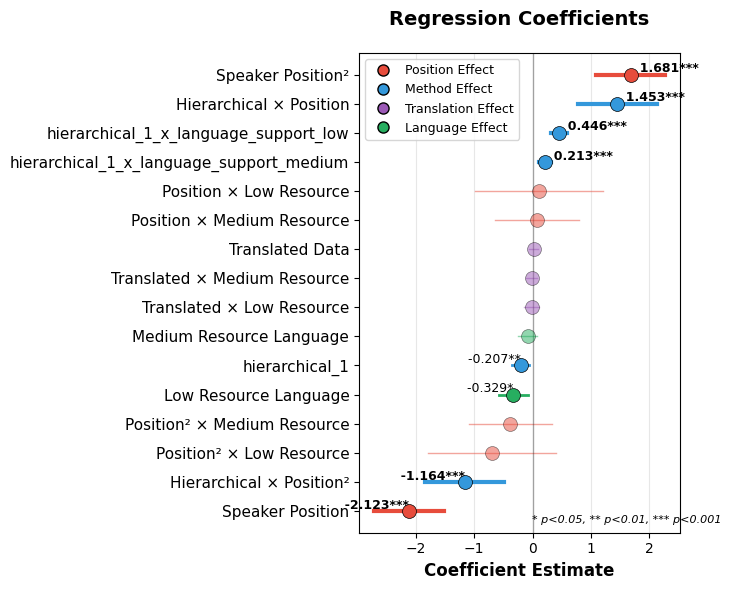

In [35]:
coef_df = extract_and_plot_coefficients(result=result, exclude_vars = ['const', 'precision'])

In [36]:
df['speaker_bin'] = df['relative_speaker_position'].apply(lambda x: int(x*10))/10

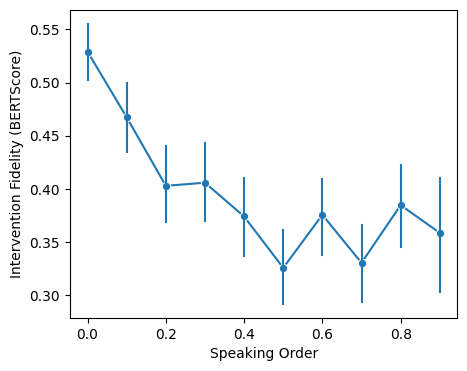

In [37]:
plt.figure(figsize = (5,4))
sns.lineplot(x = 'speaker_bin', y = 'bertscore', marker = 'o', err_style='bars', data = df[df['zero_shot']&df['translated']])
#label x-axis as speaker position
plt.xlabel('Speaking Order')
#label y-axis as bertscore
plt.ylabel('Intervention Fidelity (BERTScore)')
plt.savefig('figures/bertscore_zero_shot.png', bbox_inches='tight', dpi=300)

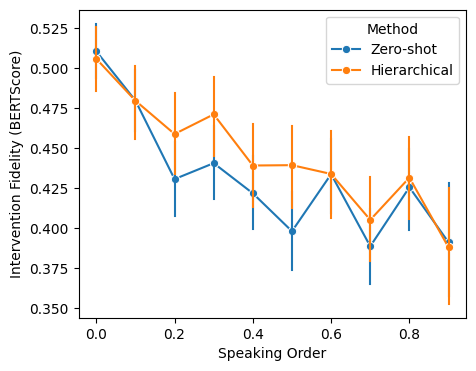

In [38]:
plt.figure(figsize = (5,4))
sns.lineplot(x = 'speaker_bin', y = 'bertscore', hue = 'hierarchical_1', marker = 'o',  err_style='bars', data = df[df['translated']])
plt.xlabel('Speaking Order')
plt.ylabel('Intervention Fidelity (BERTScore)')
plt.legend(title = 'Method', labels = ['Zero-shot', 'Hierarchical'])
plt.savefig('figures/bertscore_hierarchical.png', bbox_inches='tight', dpi=300)

In [39]:
df['method'] = df.apply(lambda x: 'No Hierarchy' if x['zero_shot'] else  '1 Level' if x['hierarchical_1'] else '2 Levels' if x['hierarchical_2'] else '', axis=1)

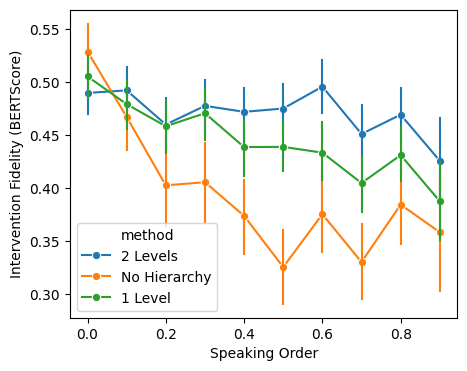

In [40]:
plt.figure(figsize = (5,4))
sns.lineplot(x = 'speaker_bin', y = 'bertscore', hue = 'method', marker = 'o',  err_style='bars', data = df[df['translated']])
plt.xlabel('Speaking Order')
plt.ylabel('Intervention Fidelity (BERTScore)')
plt.savefig('figures/bertscore_hierarchical.png', bbox_inches='tight', dpi=300)

In [75]:
df

,speech_id,lang_rank,zero_shot,generator_hierarchical,relative_speaker_position,bertscore,translated,hierarchical_1,hierarchical_2,speaker_bin,method,speaker_pos_squared,hierarchical_x_relative_speaker_position,hierarchical_x_speaker_pos_squared
0,CRE-20060404-ITEM-006_2-020,high,False,True,0.025000,0.274352,False,False,True,0.0,Hierarchical 2 step,0.000625,0.000000,0.000000
1,CRE-20060404-ITEM-006_2-021,high,False,True,0.050000,0.224527,False,False,True,0.0,Hierarchical 2 step,0.002500,0.000000,0.000000
2,CRE-20060404-ITEM-006_2-022,high,False,True,0.075000,0.294654,False,False,True,0.0,Hierarchical 2 step,0.005625,0.000000,0.000000
3,CRE-20060404-ITEM-006_2-023,high,False,True,0.100000,0.284993,False,False,True,0.1,Hierarchical 2 step,0.010000,0.000000,0.000000
4,CRE-20060404-ITEM-006_2-024,low,False,True,0.125000,0.303623,False,False,True,0.1,Hierarchical 2 step,0.015625,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6739,CRE-20060404-ITEM-017_2-380,medium,False,False,0.666667,0.594804,True,True,False,0.6,Hierarchical 1 step,0.444444,0.666667,0.444444
6740,CRE-20060404-ITEM-017_2-381,high,False,False,0.714286,0.279808,True,True,False,0.7,Hierarchical 1 step,0.510204,0.714286,0.510204
6741,CRE-20060404-ITEM-017_2-383,high,False,False,0.809524,0.587277,True,True,False,0.8,Hierarchical 1 step,0.655329,0.809524,0.655329
6742,CRE-20060404-ITEM-017_2-384,high,False,False,0.857143,0.260906,True,True,False,0.8,Hierarchical 1 step,0.734694,0.857143,0.734694


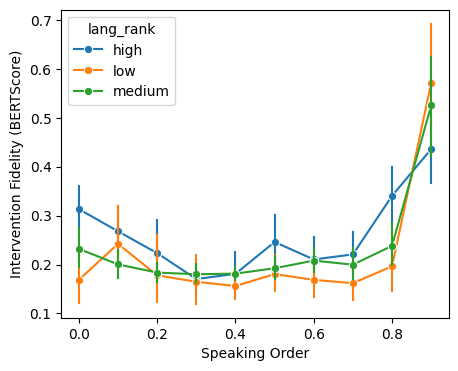

In [80]:
plt.figure(figsize = (5,4))
sns.lineplot(x = 'speaker_bin', y = 'bertscore', hue = 'lang_rank', marker = 'o',  err_style='bars', data = df[df['zero_shot']&df['translated']])
plt.xlabel('Speaking Order')
plt.ylabel('Intervention Fidelity (BERTScore)')
plt.savefig('figures/bertscore_hierarchical.png', bbox_inches='tight', dpi=300)

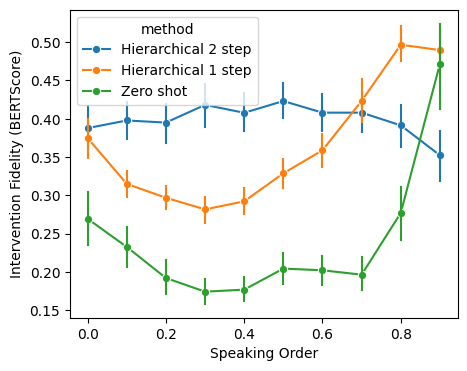

In [81]:
plt.figure(figsize = (5,4))
sns.lineplot(x = 'speaker_bin', y = 'bertscore', hue = 'method', marker = 'o',  err_style='bars', data = df[df['translated']])
plt.xlabel('Speaking Order')
plt.ylabel('Intervention Fidelity (BERTScore)')
# plt.legend(title = 'Method', labels = ['Zero-shot', 'Hierarchical'])
plt.savefig('figures/bertscore_hierarchical.png', bbox_inches='tight', dpi=300)

In [86]:
res_2['generator_model_name'].value_counts()

generator_model_name
phi4:14b                    3723
claude-sonnet-4-20250514    2396
gpt-4.1                      219
Name: count, dtype: int64